In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def volume_confirmed_sumd(df, window=60):
    """
    改进1：引入成交量确认机制
    金融逻辑：价格变动必须有成交量支持才有效，过滤噪音波动
    改进点：对价格变动用成交量加权，强化量价配合的信号
    """
    close = df['close']
    volume = df['volume']
    
    price_diff = close.diff()
    volume_weight = volume / volume.rolling(window).mean()  # 相对成交量
    
    # 成交量加权的价格变动
    gain = (price_diff * volume_weight).where(price_diff > 0, 0)
    loss = (-price_diff * volume_weight).where(price_diff < 0, 0)
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # 加入波动率调整因子
    volatility = price_diff.abs().rolling(window).std() + 1e-12
    factor = (sum_gain - sum_loss) / volatility
    
    return factor

# 因子测试

In [5]:
evaluator.set_factor(
    factor_func=volume_confirmed_sumd,
    factor_name='volume_confirmed_sumd'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.018405
   Rank_IC (Spearman): -0.020996
📊 信息比率:
   IR: 0.513218
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130822
   因子列: volume_confirmed_sumd
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


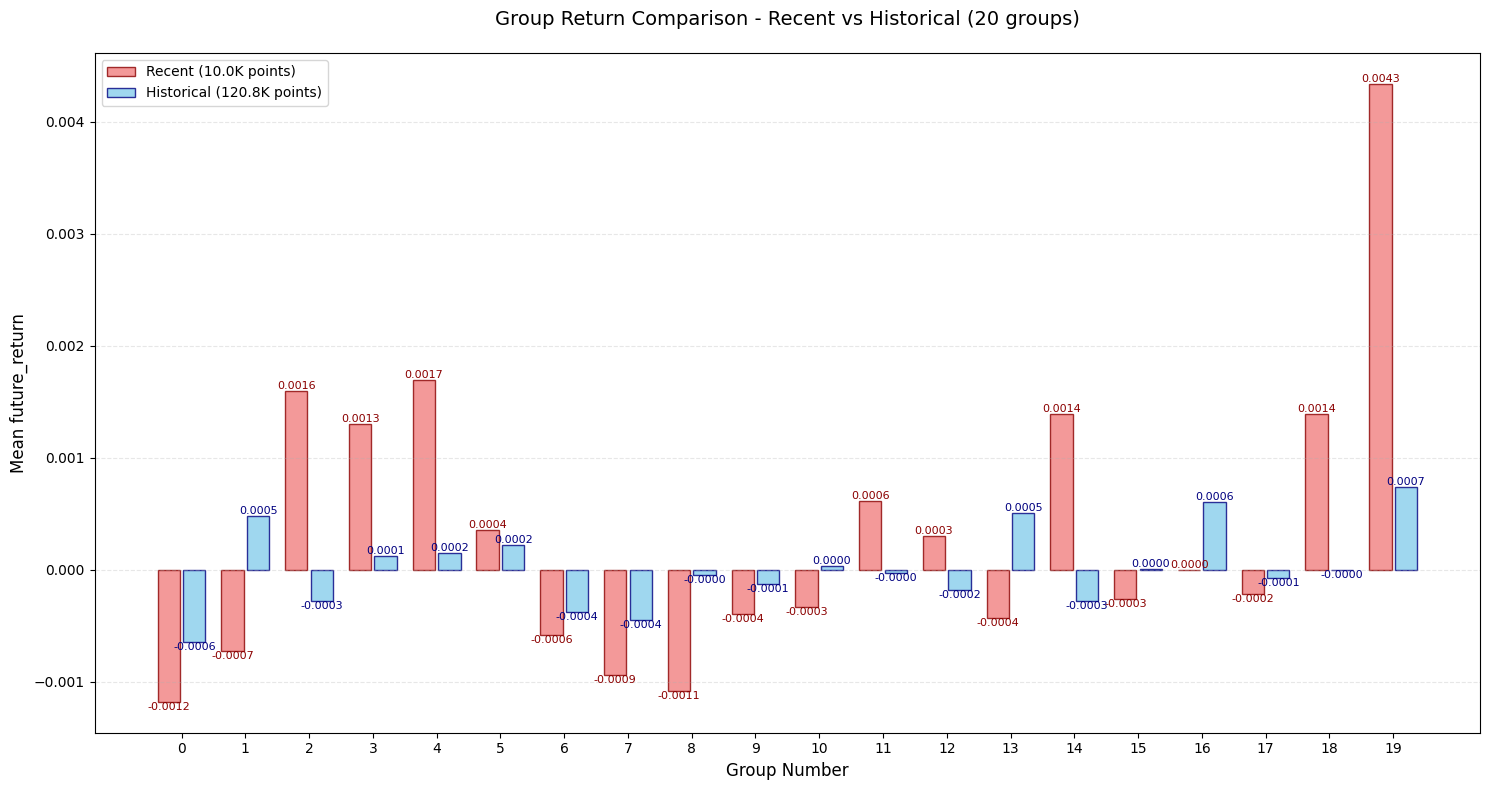

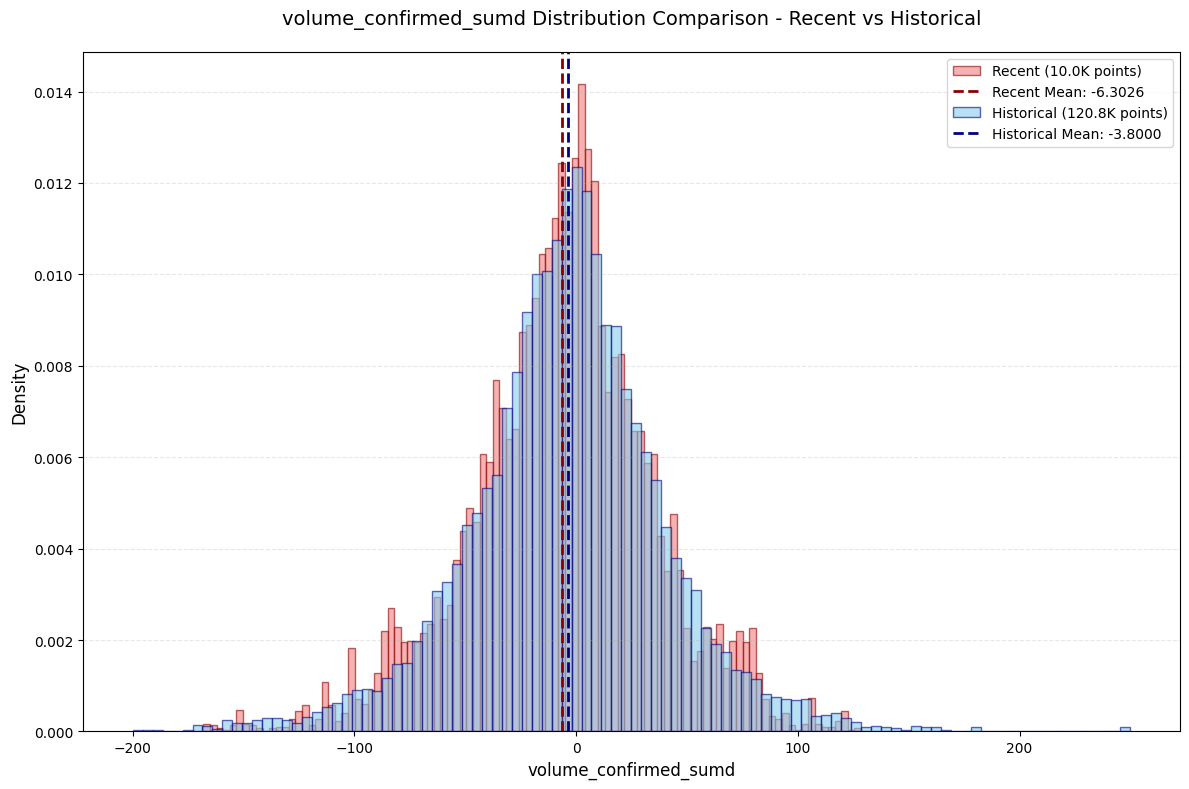

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.01840534490009577, 'Rank_IC': -0.020996382189408375}, 'information_ratio': {'IR': 0.5132179098410352, 'group_correlations': [0.04326398454860041, 0.009325472372199769, 0.0036714234748335796, 6.890815989261786e-05, -0.010587741399735465, 0.0027386150974656447, 0.026031225495194345, 0.005280569428608645, -0.020448255876109083, 0.04699108021929624], 'n_groups': 10}, 'group_analysis': {'group_stats':         val_min  val_max  val_mean  return_mean  return_std  count
group                                                             
0     -200.0133 -76.6978 -105.3887      -0.0007      0.0151   6542
1      -76.6963 -56.7153  -65.4353       0.0004      0.0121   6541
2      -56.7151 -44.6760  -50.3208      -0.0001      0.0130   6541
3      -44.6757 -35.3145  -39.9352       0.0003      0.0122   6541
4      -35.3142 -28.0750  -31.5246       0.0003      0.0118   6541
5      -28.0748 -22.0738  -24.9627       0.0002      0.0117   6541
6      -22.0725 -16.9296  -19.